# Import

In [84]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import time
import copy
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torchvision.models as models


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
torch.cuda.get_device_name()

'Tesla T4'

# Dataset

In [13]:
path = r'/content/drive/MyDrive/economic_dispatch_samples'  # use your path
data = []
li_res = []
for counter in range(1, 100):
    df = pd.read_csv(path + '/dem_data_%d.csv' % counter, usecols=['dem'])
    dem = df['dem'].to_numpy().flatten()
    dem = dem.reshape((1, dem.shape[0]))
    df = pd.read_csv(path + '/gen_data_%d.csv' % counter, usecols=['cos', 'cap'])
    gen = (df.to_numpy().flatten())
    gen = gen.reshape((1, gen.shape[0]))
    input_vector = np.concatenate((dem, gen), axis=1)
    if counter == 1:
        li = input_vector
    else:
        li = np.append(li,input_vector, axis=0)
        
    
    df = pd.read_csv(path + '/gen_result_%d.csv' % counter, usecols=['gen'])
    output_vector = (df.to_numpy().flatten())
    output_vector = output_vector.reshape((1,output_vector.shape[0]))
    if counter == 1:
        li_res = output_vector
    else:
        li_res = np.append(li_res,output_vector, axis=0)
  
    data.append(li)
   

data = li



In [ ]:
x_train = data
y_train = li_res
print(y_train.shape)
print(x_train.shape)
print(y_train)

# Initialize

In [15]:
batch_size = 10
output= y_train.shape[1]
num_features = x_train.shape[1]


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [16]:
test_ratio = 0.08
valid_ratio = 0.1



x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=test_ratio, random_state=1, shuffle=True)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=valid_ratio, random_state=1, shuffle=True)

x_train = torch.tensor(x_train).float()
x_test = torch.tensor(x_test).float()
x_valid = torch.tensor(x_valid).float()

y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()
y_valid = torch.tensor(y_valid).float()

xmean = x_train.mean(dim=0)
ymean = y_train.mean(dim=0)
xstd = x_train.std(dim=0)
ystd = y_train.std(dim=0)

x_train = (x_train - xmean) / xstd
x_test = (x_test - xmean) / xstd
x_valid = (x_valid - xmean) / xstd

y_train = (y_train - ymean) / ystd
y_test = (y_test - ymean) / ystd
y_valid = (y_valid - ymean) / ystd



In [ ]:
print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)
print(x_train[1])
print(y_train)

In [18]:
train_dataset = TensorDataset(x_train,y_train)
valid_dataset = TensorDataset(x_valid,y_valid)
test_dataset = TensorDataset(x_test,y_test)

In [19]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True, drop_last = True)
print(train_dataset)

In [20]:
one_batch_train  = next(iter(train_loader))
# print(one_batch_train.shape)


In [ ]:
for batch_number, (x_train, y_train) in enumerate(train_loader):
  print(batch_number, x_train.shape)

# Model

In [85]:
class res_block_1d(nn.Module):
    def __init__(self, in_dim, out_dim, activation=nn.ReLU):
        super(res_block_1d, self).__init__()
        self.activation = activation()
        self.block = nn.Sequential(
            nn.BatchNorm1d(out_dim),
            nn.Linear(in_dim, out_dim),
            activation(),
            nn.BatchNorm1d(out_dim),
            nn.Linear(out_dim, out_dim),
            activation(),
        )

    def forward(self, x):
        out = self.activation(self.block(x) + x)

        return out

class resnet(nn.Module):
    def __init__(self, output):
        super(resnet, self).__init__()
        self.net = nn.Sequential(
            res_block_1d(num_features, num_features),
            res_block_1d(num_features, num_features),
            nn.Linear(num_features, output)
        )

    def forward(self, x):
        out = self.net(x)

        return out


In [86]:
model = resnet(output).to(device)
print(model)

# Config

In [88]:

# criterion = nn.CrossEntropyLoss()
loss = nn.MSELoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Trainer

In [89]:
dataloaders_dict = {'train': train_loader, 'val': valid_loader}
num_epochs = 1000

In [90]:
def train_model(model, dataloaders, loss, optimizer, num_epochs=num_epochs):
    since = time.time()

    val_acc_history = []
    train_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    min_loss = float("inf")

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, y_train in dataloaders[phase]:
                inputs = inputs.to(device)
                y_train = y_train.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                   
                    outputs = model(inputs)
                  
                    loss_value = loss(outputs, y_train)
                    #print('a=',loss_value)
                    #_, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item() * inputs.size(0)
                #running_corrects += torch.sum(preds == y_train.data)
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            #epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} '.format(phase, epoch_loss))
            
            # deep copy the model
            if phase == 'val' and epoch_loss < min_loss:
                min_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_loss)
            else:
                train_acc_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    # print('Best val Acc: {:4f}'.format(0))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history

In [ ]:
model, val_hist, train_hist = train_model(model, dataloaders_dict, loss, optimizer, num_epochs=num_epochs)

Plot

In [ ]:
# # Plot the training curves of validation accuracy vs. number
# #  of training epochs 

plt.title("Test Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),val_hist,label="Pretrained")
plt.xticks(np.arange(0, num_epochs+1, 100.0))
plt.legend()
plt.show()


plt.title("Train Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training Accuracy")
plt.plot(range(1,num_epochs+1),train_hist,label="Pretrained")
plt.xticks(np.arange(0, num_epochs+1, 100.0))
plt.legend()
plt.show()





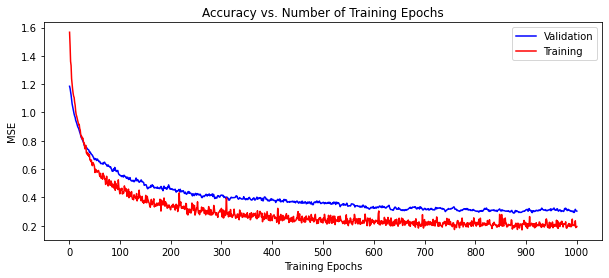

In [93]:
plt.figure(figsize=(10,4))
plt.plot(range(1,num_epochs+1),val_hist, color = "blue",label = "Validation")
plt.plot(range(1,num_epochs+1),train_hist, color = 'red',label = "Training")
plt.title("Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel('MSE')
plt.xticks(np.arange(0, num_epochs+1, 100.0))
plt.legend()
plt.show()